<a href="https://colab.research.google.com/github/mordor-ai/deep_learning/blob/master/DEEP_LEARNING_TRANSFERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import skimage as skimage


In [0]:



def get_image (img_path, size=  256):
  img=  mpimg.imread(img_path)
  ig = img[:,:,::-1] # RGB to BGR ?
  short_edge=  min(img.shape[:2])
  yy=  int((img.shape[0]- short_edge)/2)
  xx = int((img.shape[1]-short_edge)/2)
  crop_img =  img[yy:yy + short_edge, xx:yy +short_edge]
  resized_img = skimage.transform.resize(crop_img,(size,size))
  return resized_img


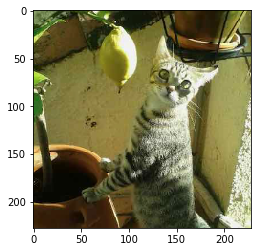

In [27]:

SIZE=228
imRef = get_image("IMG_0863.jpeg", SIZE)
imStyle=  get_image("pompidou-lam-La-Junge.jpg",SIZE)



plt.imshow(imRef)
plt.show()

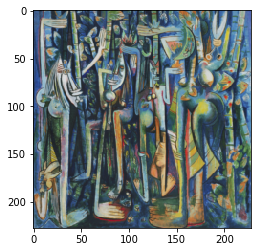

In [28]:
plt.imshow(imStyle)
plt.show()

In [29]:
!wget --output-document=vgg19.npy https://media.githubusercontent.com/media/tensorlayer/pretrained-models/master/models/vgg19.npy

class Vgg19:
  def __init__(self, vgg19_npy_path="./vgg19.npy", reuse=False, name="vgg19"):
    self.data_dict = np.load(vgg19_npy_path, encoding='latin1', allow_pickle=True).item()
    self.reuse = reuse
    self.name = name
    self.couches ={}
## appelle et construit le graphe pour que chaque poids soit dnas le bon ordre
  def build(self, couche_in, withFC):
    self.couches["IN"] = couche_in
    couche_in = couche_in - tf.constant(np.array([103.939, 116.779, 123.68]).reshape((1, 1, 1, 3)), dtype='float32')
    with tf.variable_scope(self.name, reuse=self.reuse):
      struct = ["conv1_1", "conv1_2", "pool1","conv2_1", "conv2_2", 'pool2',
             "conv3_1","conv3_2","conv3_3","conv3_4","pool3","conv4_1",
             "conv4_2","conv4_3","conv4_4","pool4","conv5_1","conv5_2",
             "conv5_3","conv5_4", "pool5", "fc6", "fc7"]
      tmp = couche_in
      for line in struct:
        if line[:4]=="conv":
          tmp = self.conv_layer(tmp, line)
        elif line[:4]=="pool":
          tmp = self.max_pool(tmp, line)
        elif withFC:
          tmp = self.fc_layer(tmp, line, relu=True)
      self.data_dict = None

  def get(self, name):
    return self.couches[name]

  def max_pool(self, bottom, name):
    return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

  def conv_layer(self, bottom, name):
    with tf.variable_scope(name):
      filt = tf.constant(self.data_dict[name][0], name="filter")
      conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')
      conv_biases = tf.constant(self.data_dict[name][1], name="biases")
      bias = tf.nn.bias_add(conv, conv_biases)
      relu = tf.nn.relu(bias)
      self.couches[name] = relu
      return relu

  def fc_layer(self, bottom, name, relu):
    with tf.variable_scope(name):
      x = tf.contrib.layers.flatten(bottom)
      weights = tf.constant(self.data_dict[name][0], name="weights")
      biases = tf.constant(self.data_dict[name][1], name="biases")
      fc = tf.nn.bias_add(tf.matmul(x, weights), biases)
      if relu:
        fc = tf.nn.relu(fc)
      self.couches[name] = fc
      return fc



--2020-02-10 15:04:05--  https://media.githubusercontent.com/media/tensorlayer/pretrained-models/master/models/vgg19.npy
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574670860 (548M) [application/octet-stream]
Saving to: ‘vgg19.npy’

vgg19.npy           100%[===================>] 548.05M   174MB/s    in 3.4s    

2020-02-10 15:04:09 (159 MB/s) - ‘vgg19.npy’ saved [574670860/574670860]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


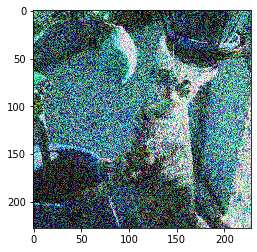

In [34]:
img_mod=  imRef+ (np.random.rand(SIZE,SIZE,3)-0.5)*1.0
plt.imshow(img_mod[:,:,::-1])
plt.show()

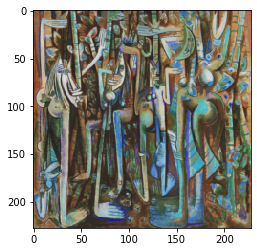

In [36]:

plt.imshow(imStyle[:,:,::-1])
plt.show()

In [0]:
batchMod =  img_mod.reshape((1,SIZE,SIZE,3)).astype(np.float32)
batchRef =  imRef.reshape((1,SIZE,SIZE,3)).astype(np.float32)
batchStyle =  imStyle.reshape((1,SIZE,SIZE,3)).astype(np.float32)

In [0]:
tf.reset_default_graph()
sess=  tf.Session()
vggRef=  Vgg19('./vgg19.npy', reuse=False, name="vgg19")
couche_entree =  tf.constant(batchRef, name="in_ref")
vggRef.build(couche_in = couche_entree, withFC=False )


In [0]:
couche_entree =  tf.constant(batchStyle, name="in_style")
vggRef.build(couche_in = couche_entree, withFC=False )
couche_entree =  tf.constant(batchMod, name="in_mod")
vggRef.build(couche_in = couche_entree, withFC=False )

# Nouvelle section